#Worksheet-6

##Importing Necessary Tools

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

##Task-1

In [4]:
train_data = "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/Week5Workshop5/FruitinAmazon/train"
test_data = "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/Week5Workshop5/FruitinAmazon/test"

In [5]:
class_names = os.listdir(train_data)
print(f"Classes: {class_names}")

Classes: ['guarana', 'cupuacu', 'graviola', 'acai', 'tucuma', 'pupunha']


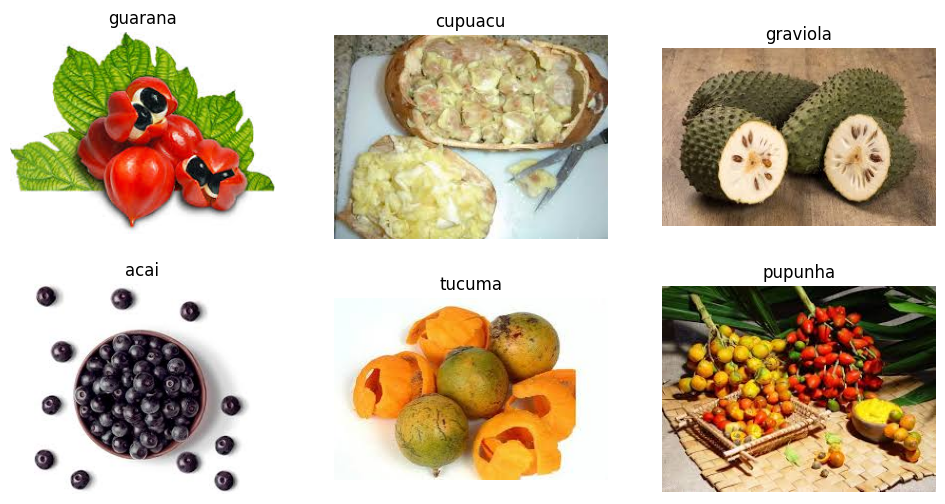

In [6]:
def visualize_images(train_data, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_data, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_data, class_names)

In [7]:
corrupt_images = []
for class_name in class_names:
    class_path = os.path.join(train_data, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)
        except (IOError, SyntaxError):
            corrupt_images.append(img_path)
            os.remove(img_path)
            print(f"Corrupt image removed: {img_path}")

if not corrupt_images:
    print("No corrupt Images Found.")

No corrupt Images Found.


In [8]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

In [10]:
train_ds = train_datagen.flow_from_directory(
    train_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=123
)

Found 72 images belonging to 6 classes.


In [11]:
val_ds = val_datagen.flow_from_directory(
    train_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False,
    seed=123
)

Found 18 images belonging to 6 classes.


In [12]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,651,398 (128.37 MB)

 Trainable params: 33,650,438 (128.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    batch_size=16,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2301 - loss: 3.2178

3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.2420 - loss: 3.2203 - val_accuracy: 0.2778 - val_loss: 2.7693 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4554 - loss: 2.4537

3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.4527 - loss: 2.4701 - val_accuracy: 0.3333 - val_loss: 2.7956 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step - accuracy: 0.5722 - loss: 2.8940 - val_accuracy: 0.1667 - val_loss: 2.9087 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.4805 - loss: 2.5198 - val_accuracy: 0.2222 - val_loss: 3.1977 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.5620 - loss: 2.6666 - val_accuracy: 0.1111 - val_loss: 3.9708 - learning_rate: 5.0000e-04
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.6064 - loss: 2.5518 - val_accuracy: 0.1111 - val_loss: 5.0240 - learning_rate: 5.0000e-04


In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 30 images belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 2.6203
Test Accuracy: 40.00%


In [16]:
model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [17]:
y_true = test_ds.classes
y_pred = np.argmax(loaded_model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

     guarana       0.33      1.00      0.50         5
     cupuacu       0.00      0.00      0.00         5
    graviola       0.00      0.00      0.00         5
        acai       0.33      0.40      0.36         5
      tucuma       0.56      1.00      0.71         5
     pupunha       0.00      0.00      0.00         5

    accuracy                           0.40        30
   macro avg       0.20      0.40      0.26        30
weighted avg       0.20      0.40      0.26        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


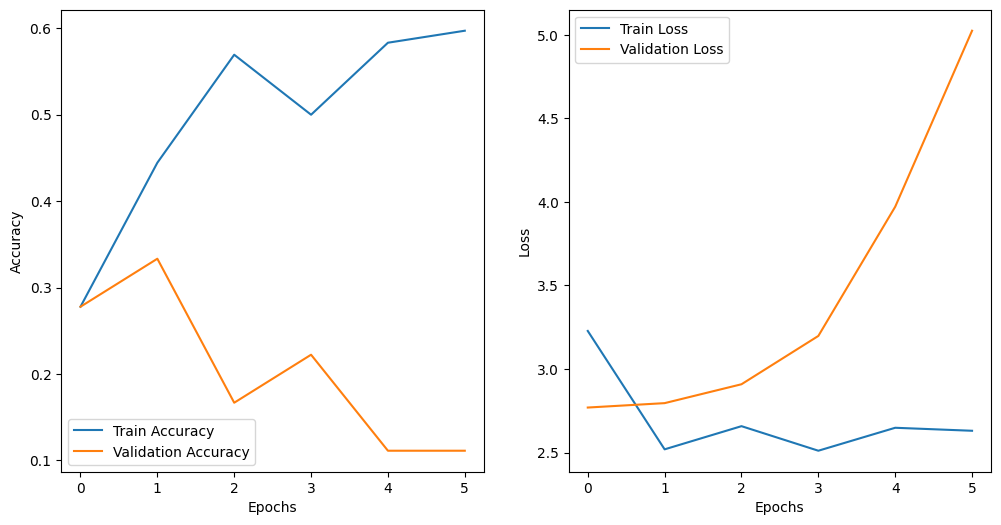

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##Task-2

In [19]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
callbacks = [
    ModelCheckpoint("best_model1.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.1648 - loss: 2.4028

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.1722 - loss: 2.3480 - val_accuracy: 0.4444 - val_loss: 1.5408 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.2171 - loss: 1.9473

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 835ms/step - accuracy: 0.2288 - loss: 1.9404 - val_accuracy: 0.6111 - val_loss: 1.1846 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6187 - loss: 1.0849 - val_accuracy: 0.5556 - val_loss: 1.0759 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.6887 - loss: 0.9485

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6970 - loss: 0.9338 - val_accuracy: 0.6667 - val_loss: 0.9821 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8088 - loss: 0.5748

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 768ms/step - accuracy: 0.7976 - loss: 0.5883 - val_accuracy: 0.7222 - val_loss: 0.8487 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8111 - loss: 0.5387

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 965ms/step - accuracy: 0.8167 - loss: 0.5368 - val_accuracy: 0.7778 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8843 - loss: 0.3704

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 720ms/step - accuracy: 0.8889 - loss: 0.3566 - val_accuracy: 0.8333 - val_loss: 0.5822 - learning_rate: 0.0010
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8247 - loss: 0.4449

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - accuracy: 0.8268 - loss: 0.4428 - val_accuracy: 0.8889 - val_loss: 0.5349 - learning_rate: 0.0010
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8882 - loss: 0.3099 - val_accuracy: 0.8889 - val_loss: 0.5029 - learning_rate: 0.0010
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 826ms/step - accuracy: 0.9215 - loss: 0.2267 - val_accuracy: 0.8889 - val_loss: 0.5230 - learning_rate: 0.0010
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 837ms/step - accuracy: 0.9667 - loss: 0.1364 - val_accuracy: 0.8333 - val_loss: 0.5671 - learning_rate: 0.0010
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8646 - loss: 0.2702 - val_accuracy: 0.8333 - val_loss: 0.6292 - learning_rate: 0.0010
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 895ms/step - accuracy: 0.9354 - loss: 0.2139 - val_accuracy: 0.8333 - val_loss: 0.6310 - learning_rate: 5.0000e-04
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9651 - loss: 0.1561 - val_accuracy: 0.8333 - va

In [23]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - accuracy: 0.8667 - loss: 0.3980
Test Accuracy: 86.67%


In [24]:
model.save("final_model1.h5")

loaded_model = tf.keras.models.load_model("final_model1.h5")

In [25]:
y_true = test_ds.classes
y_pred_probs = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Inference Output: First 20 Samples:")
for i in range(20):
    true_label = class_names[int(y_true[i])]
    pred_label = class_names[int(y_pred[i])]
    print(f"{i+1}. True: {true_label} - Predicted: {pred_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Inference Output: First 20 Samples:
1. True: guarana - Predicted: guarana
2. True: guarana - Predicted: guarana
3. True: guarana - Predicted: pupunha
4. True: guarana - Predicted: cupuacu
5. True: guarana - Predicted: tucuma
6. True: cupuacu - Predicted: cupuacu
7. True: cupuacu - Predicted: cupuacu
8. True: cupuacu - Predicted: cupuacu
9. True: cupuacu - Predicted: cupuacu
10. True: cupuacu - Predicted: cupuacu
11. True: graviola - Predicted: graviola
12. True: graviola - Predicted: graviola
13. True: graviola - Predicted: graviola
14. True: graviola - Predicted: graviola
15. True: graviola - Predicted: graviola
16. True: acai - Predicted: acai
17. True: acai - Predicted: acai
18. True: acai - Predicted: acai
19. True: acai - Predicted: acai
20. True: acai - Predicted: acai


In [26]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

     guarana       0.67      0.40      0.50         5
     cupuacu       0.83      1.00      0.91         5
    graviola       1.00      1.00      1.00         5
        acai       1.00      1.00      1.00         5
      tucuma       0.83      1.00      0.91         5
     pupunha       0.80      0.80      0.80         5

    accuracy                           0.87        30
   macro avg       0.86      0.87      0.85        30
weighted avg       0.86      0.87      0.85        30



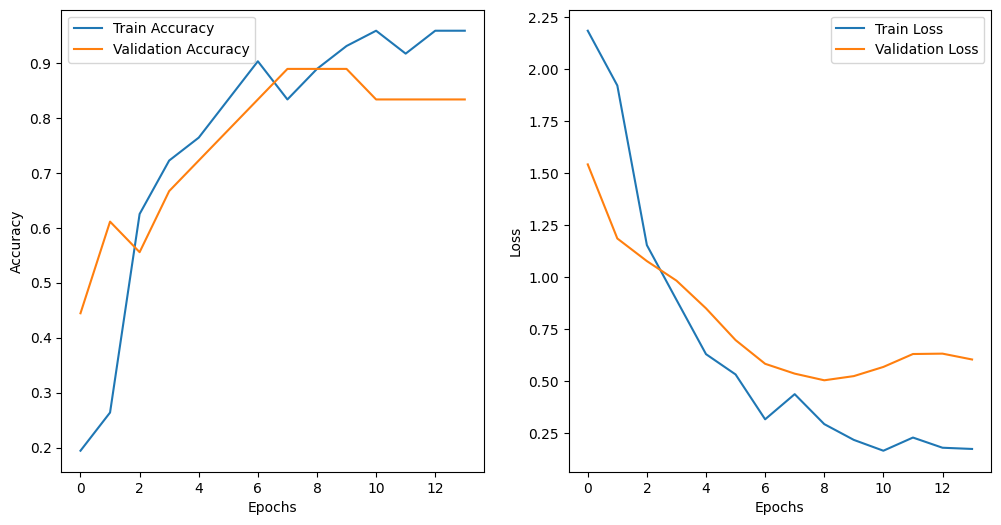

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()